In [25]:
import skimage 
import numpy as np
import matplotlib.pyplot as plt

In [26]:
img = skimage.io.imread('image.png')

In [27]:
# convert image to hsv using skimage
img_hsv = skimage.color.rgb2hsv(img)


In [28]:
mask_blue = (img_hsv[:,:,0] > 0.5) & (img_hsv[:,:,0] < 0.8) & (img_hsv[:,:,1] > 0.5) & (img_hsv[:,:,2] > 0.5)
mask_yellow = (img_hsv[:,:,0] > 0.1) & (img_hsv[:,:,0] < 0.2) & (img_hsv[:,:,1] > 0.5) & (img_hsv[:,:,2] > 0.5)

In [29]:
mask_zeros = np.zeros_like(img_hsv[:,:,0])

mask_zeros[mask_blue] = -1
mask_zeros[mask_yellow] = 1



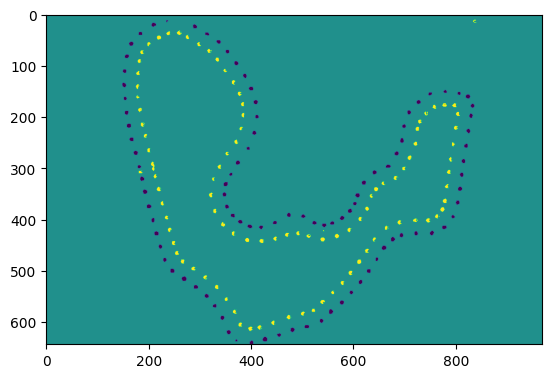

In [30]:
plt.imshow(mask_zeros)

In [31]:
from skimage import measure
# import area closing function
from skimage.morphology import area_closing


# close small holes
mask_blue_closed = area_closing(mask_blue, area_threshold=11)
cc = measure.label(mask_blue_closed, connectivity=2)

blue_centers = []

for i in range(1, cc.max()+1):
    blue_centers.append(np.mean(np.where(cc == i), axis=1))

blue_centers = np.array(blue_centers)


mask_yellow_closed = area_closing(mask_yellow, area_threshold=11)
cc = measure.label(mask_yellow_closed, connectivity=2)

yellow_centers = []

for i in range(1, cc.max()+1):
    yellow_centers.append(np.mean(np.where(cc == i), axis=1))

yellow_centers = np.array(yellow_centers)

(-18.089246119733925, 671.8741685144124, 117.98055555555555, 870.8898148148148)

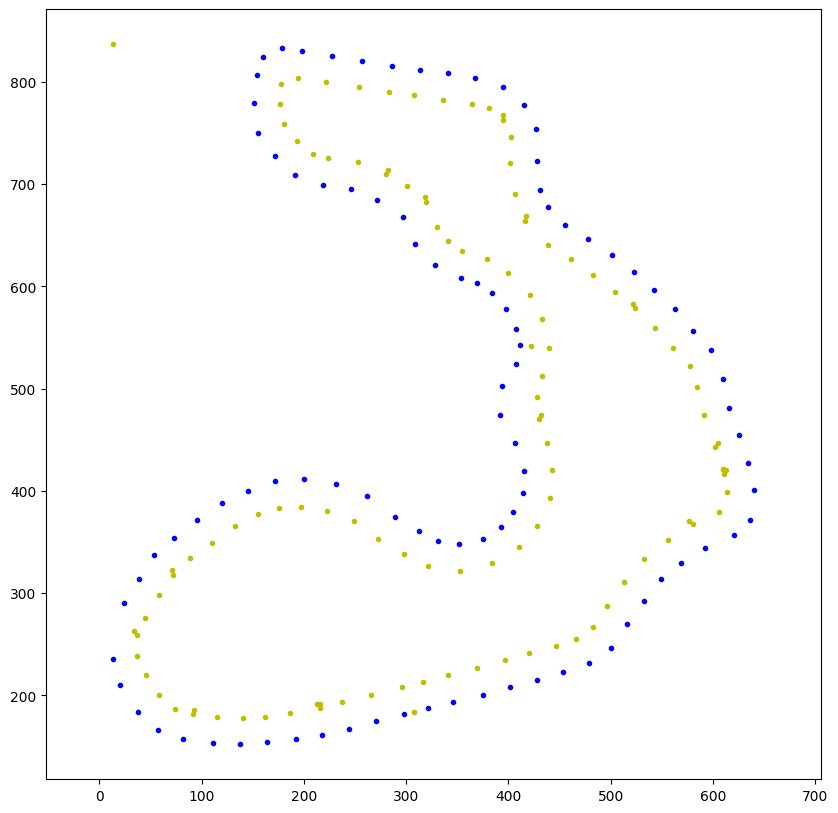

In [32]:
plt.figure(figsize=(10,10))

plt.plot(blue_centers[:,0], blue_centers[:,1], 'b.')
plt.plot(yellow_centers[:,0], yellow_centers[:,1], 'y.')

plt.axis('equal')


/home/papalotis/repos/fsg23-approximate-dv-track/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/papalotis/repos/fsg23-approximate-dv-track/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/papalotis/repos/fsg23-approximate-dv-track/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/papalotis/repos/fsg23-approximate-dv-track/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


(-18.089246119733925, 671.8741685144124, 117.98055555555555, 870.8898148148148)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


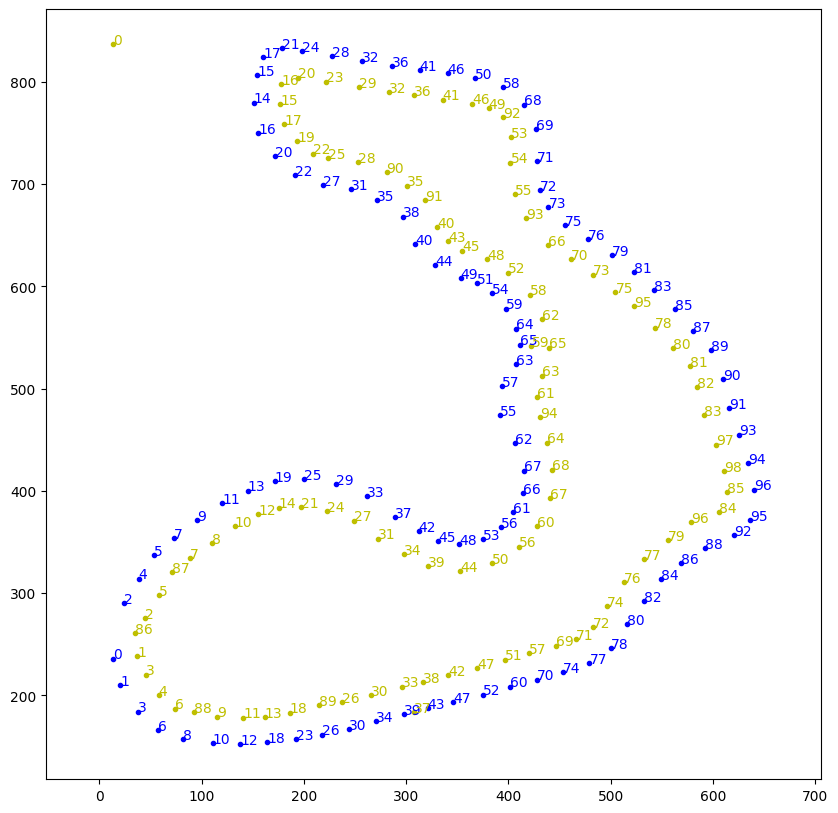

In [33]:
# cluster points to find centers that are very close to each other
# in those cases we found the same center twice
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=10, min_samples=2).fit(blue_centers)

blue_centers_clustered = blue_centers[db.labels_ == -1]

for i in range(1, len(set(db.labels_))+1):
    center_points = blue_centers[db.labels_ == i]
    new_center = np.mean(center_points, axis=0)
    blue_centers_clustered = np.vstack((blue_centers_clustered, new_center))

db = DBSCAN(eps=10, min_samples=2).fit(yellow_centers)

yellow_centers_clustered = yellow_centers[db.labels_ == -1]

for i in range(0, len(set(db.labels_))+1):
    center_points = yellow_centers[db.labels_ == i]
    new_center = np.mean(center_points, axis=0)
    yellow_centers_clustered = np.vstack((yellow_centers_clustered, new_center))

plt.figure(figsize=(10,10))
plt.plot(blue_centers_clustered[:,0], blue_centers_clustered[:,1], 'b.')
plt.plot(yellow_centers_clustered[:,0], yellow_centers_clustered[:,1], 'y.')

# show index of each center
for i in range(len(blue_centers_clustered)):
    plt.text(blue_centers_clustered[i,0], blue_centers_clustered[i,1], i, color='b')

for i in range(len(yellow_centers_clustered)):
    plt.text(yellow_centers_clustered[i,0], yellow_centers_clustered[i,1], i, color='y')

plt.axis('equal')


In [34]:
from spline_fit import SplineFitterFactory

In [35]:
# remove yellow centers of index 37 and 59
yellow_centers_clustered_manual = np.delete(yellow_centers_clustered, [37, 59], axis=0)

# blue needs a cones between cones 0 and 2, put in the middle of the two in inital position
# then fit a b-spline close points 1, 0, 2, 4 and select the point that is closest to the initial position on the circle
# as the new cone position



 
new_blue_init = np.mean(blue_centers_clustered[[0,2]], axis=0)

points = blue_centers_clustered[[1,0,2,4]]
ev = SplineFitterFactory(smoothing=0.01, predict_every=1.0, max_deg=3).fit(points)

new_points = ev.predict(der=0)

distances = np.linalg.norm(new_points - new_blue_init, axis=1)
idx = np.argmin(distances)

new_blue = new_points[idx]

blue_centers_clustered_manual = np.vstack((blue_centers_clustered, new_blue))


# filter all infinities and nans
blue_centers_clustered_manual = blue_centers_clustered_manual[np.isfinite(blue_centers_clustered_manual).all(axis=1)]
yellow_centers_clustered_manual = yellow_centers_clustered_manual[np.isfinite(yellow_centers_clustered_manual).all(axis=1)]

(-18.089246119733925, 671.8741685144124, 117.98055555555555, 870.8898148148148)

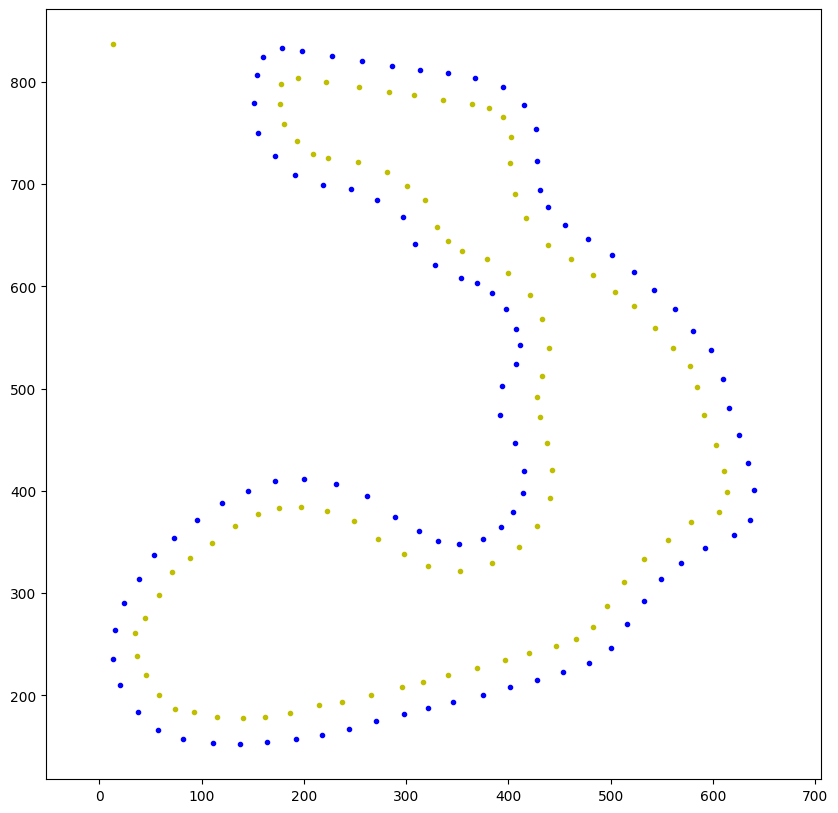

In [36]:
plt.figure(figsize=(10,10))
plt.plot(blue_centers_clustered_manual[:,0], blue_centers_clustered_manual[:,1], 'b.')
plt.plot(yellow_centers_clustered_manual[:,0], yellow_centers_clustered_manual[:,1], 'y.')
plt.axis('equal')


In [37]:
# find distances between all blue and yellow cones
from scipy.spatial.distance import cdist

distances = cdist(blue_centers_clustered_manual, yellow_centers_clustered_manual)

# find the closest yellow cone to each blue cone
min_dist = np.min(distances)

# we want the minimum width of the track to be 3.1m
# so scale the track so that the minimum distance between blue and yellow cones is 3.1m
scale = 3.1 / min_dist

# scale the yellow cones
yellow_centers_clustered_manual_scaled = yellow_centers_clustered_manual * scale

# scale the blue cones
blue_centers_clustered_manual_scaled = blue_centers_clustered_manual * scale


(-2.6513672306710783,
 98.47757843209077,
 17.292582387671654,
 127.64759245584126)

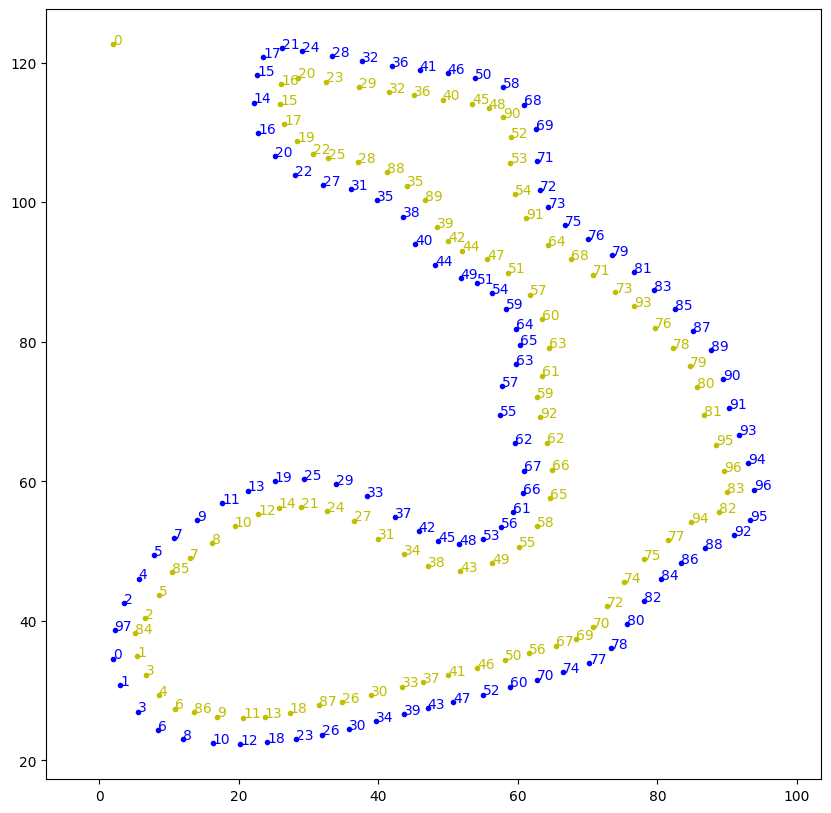

In [38]:
plt.figure(figsize=(10,10))
plt.plot(blue_centers_clustered_manual_scaled[:,0], blue_centers_clustered_manual_scaled[:,1], 'b.')
plt.plot(yellow_centers_clustered_manual_scaled[:,0], yellow_centers_clustered_manual_scaled[:,1], 'y.')

# show index of each center
for i in range(len(blue_centers_clustered_manual_scaled)):
    plt.text(blue_centers_clustered_manual_scaled[i,0], blue_centers_clustered_manual_scaled[i,1], i, color='b')

for i in range(len(yellow_centers_clustered_manual_scaled)):
    plt.text(yellow_centers_clustered_manual_scaled[i,0], yellow_centers_clustered_manual_scaled[i,1], i, color='y')

plt.axis('equal')

In [39]:
# remove points that are very far away from any other point of the other color
cutoff_distance = 10

# find distances between all blue and yellow cones
from scipy.spatial.distance import cdist

distances = cdist(blue_centers_clustered_manual_scaled, yellow_centers_clustered_manual_scaled)

# for each yellow cones find the smallest distance to a blue cone
min_dist = np.min(distances, axis=0)

# remove yellow cones that are too far away from any blue cone
yellow_centers_clustered_manual_scaled = yellow_centers_clustered_manual_scaled[min_dist < cutoff_distance]

# find distances between all blue and yellow cones
min_dist = np.min(distances, axis=1)

# remove blue cones that are too far away from any yellow cone
blue_centers_clustered_manual_scaled = blue_centers_clustered_manual_scaled[min_dist < cutoff_distance]

(-2.6513672306710783,
 98.47757843209077,
 17.320105250888442,
 127.06961232828874)

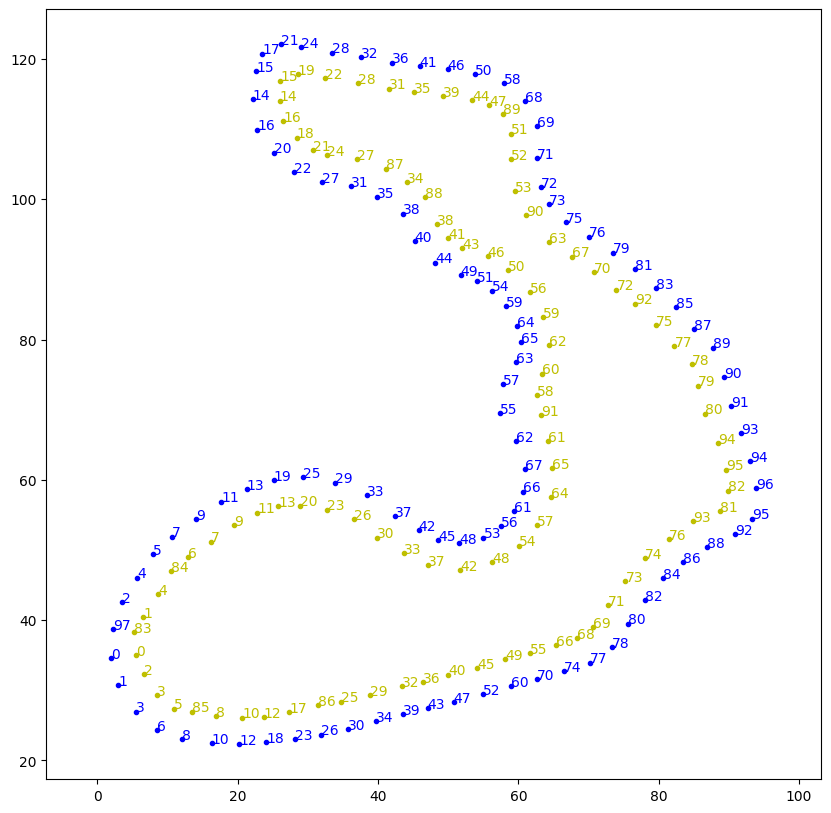

In [40]:
plt.figure(figsize=(10,10))
plt.plot(blue_centers_clustered_manual_scaled[:,0], blue_centers_clustered_manual_scaled[:,1], 'b.')
plt.plot(yellow_centers_clustered_manual_scaled[:,0], yellow_centers_clustered_manual_scaled[:,1], 'y.')

# show index of each center
for i in range(len(blue_centers_clustered_manual_scaled)):
    plt.text(blue_centers_clustered_manual_scaled[i,0], blue_centers_clustered_manual_scaled[i,1], i, color='b')

for i in range(len(yellow_centers_clustered_manual_scaled)):
    plt.text(yellow_centers_clustered_manual_scaled[i,0], yellow_centers_clustered_manual_scaled[i,1], i, color='y')

plt.axis('equal')

(-2.6513672306710783,
 98.47757843209077,
 17.320105250888442,
 127.06961232828874)

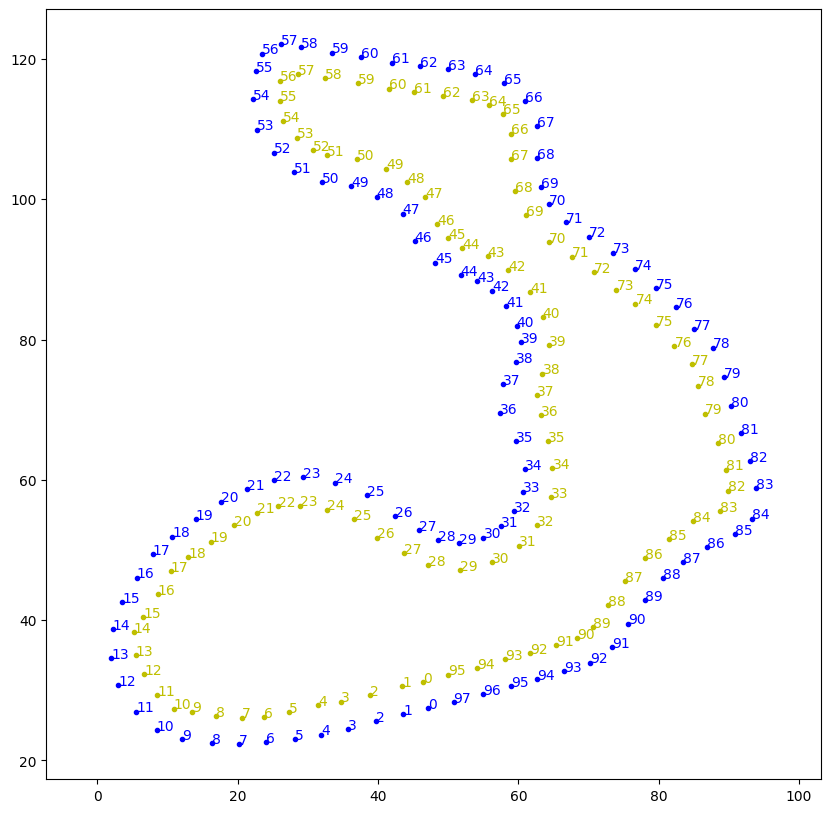

In [41]:
# first two idxs of blue are 43, 39
# first two idxs of yellow are 36, 32

def sort_cones(cones, start_idxs):
    assert len(start_idxs) == 2, "start_idxs must have length 2"

    cones_ordered_idx = start_idxs.copy()
    current_direction = np.diff(cones[start_idxs[:2]], axis=0)

    for i in range(len(cones)-len(start_idxs)):
        distances = np.linalg.norm(cones - cones[cones_ordered_idx[-1]], axis=1)
        distances[cones_ordered_idx] = np.inf

        # set all cones where the angle between the vector between the current cone and the next cone and the current direction
        # is greater than 90 degrees to infinity
        # this way we will always select the cone that is closest to the current direction
        current_cones_to_next = cones - cones[cones_ordered_idx[-1]]
        current_cones_to_next[cones_ordered_idx] = [1000, 100000]
        current_cones_to_next = current_cones_to_next / np.linalg.norm(current_cones_to_next, axis=1, keepdims=True)
        current_direction = current_direction / np.linalg.norm(current_direction)

        angles = np.arccos(np.clip(np.sum(current_cones_to_next * current_direction, axis=1), -1.0, 1.0))
        distances[angles > np.pi/2] = np.inf

        next_idx = np.argmin(distances)
        cones_ordered_idx.append(next_idx)

        current_direction = cones[next_idx] - cones[cones_ordered_idx[-2]]

    

    return cones[cones_ordered_idx]

blue_cones_ordered = sort_cones(blue_centers_clustered_manual_scaled, [43, 39])

yellow_cones_ordered = sort_cones(yellow_centers_clustered_manual_scaled, [36, 32])

plt.figure(figsize=(10,10))
plt.plot(blue_cones_ordered[:,0], blue_cones_ordered[:,1], 'b.')
plt.plot(yellow_cones_ordered[:,0], yellow_cones_ordered[:,1], 'y.')
# show index of each center
for i in range(len(blue_cones_ordered)):
    plt.text(blue_cones_ordered[i,0], blue_cones_ordered[i,1], i, color='b')

for i in range(len(yellow_cones_ordered)):
    plt.text(yellow_cones_ordered[i,0], yellow_cones_ordered[i,1], i, color='y')

plt.axis('equal')

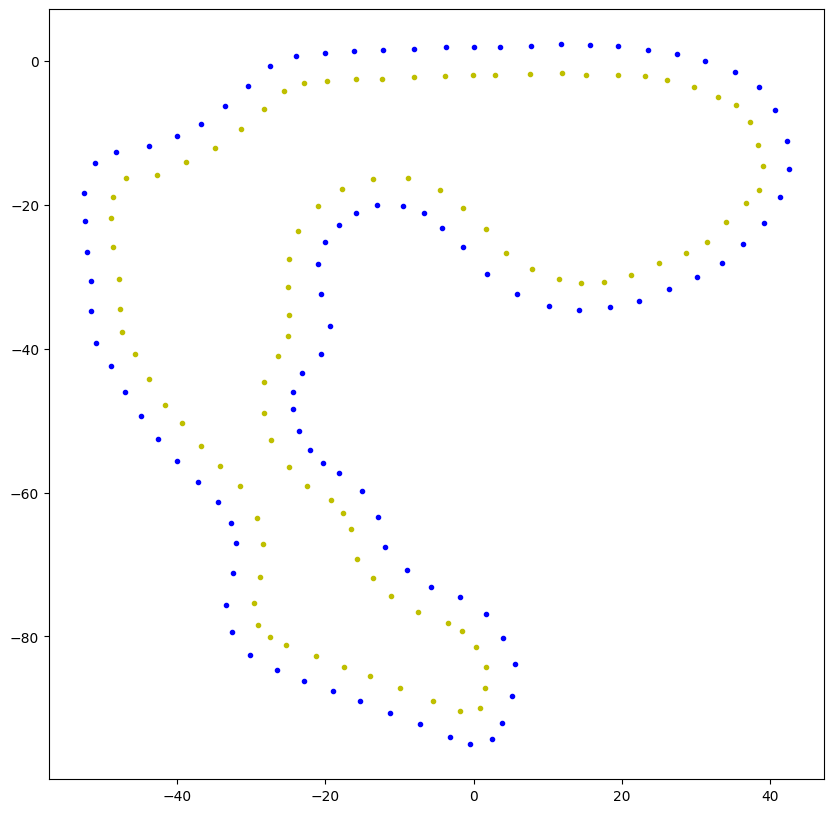

In [42]:
# center points 
all_cones = np.vstack((blue_cones_ordered, yellow_cones_ordered))

# find the center of the track
center = (blue_cones_ordered[0] + yellow_cones_ordered[0]) / 2

first_direction_blue = blue_cones_ordered[1] - blue_cones_ordered[0]

first_direction_yellow = yellow_cones_ordered[1] - yellow_cones_ordered[0]
# normalize the vectors
first_direction_blue = first_direction_blue / np.linalg.norm(first_direction_blue)
first_direction_yellow = first_direction_yellow / np.linalg.norm(first_direction_yellow)


# find the direction of the track
track_direction = (first_direction_blue + first_direction_yellow) / 2


# move the center of the track to the origin
blue_cones_centered = blue_cones_ordered - center
yellow_cones_centered = yellow_cones_ordered - center

def rotate_2d(points, angle):
    rot_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return np.dot(points, rot_matrix)

# rotate the track so that the track direction is aligned with the x-axis
angle = np.arctan2(track_direction[1], track_direction[0])
blue_cones_centered_aligned = rotate_2d(blue_cones_centered, angle)
yellow_cones_centered_aligned = rotate_2d(yellow_cones_centered, angle)

plt.figure(figsize=(10,10))
plt.plot(blue_cones_centered_aligned[:,0], blue_cones_centered_aligned[:,1], 'b.')
plt.plot(yellow_cones_centered_aligned[:,0], yellow_cones_centered_aligned[:,1], 'y.')



In [43]:
import json

out = {
    "blue": blue_cones_centered_aligned.tolist(),
    "yellow": yellow_cones_centered_aligned.tolist()
}

string = json.dumps(out, indent=2)

# print(string)

In [44]:
from pathlib import Path

Path("track.json").write_text(string)

12530